In [ ]:
import numpy as np
import time as time
from scipy.spatial.distance import pdist
from scale.nystrom import KRRNystrom, generate_data
from scale.rff import KRRRFF, KRRRBFSampler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, pairwise_kernels

### Get Data

In [2]:
random_state = 123      # reproducibility

x_train, x_test, y_train, y_test = generate_data(random_state=random_state)

### Experimental Parameters

In [3]:
n_components = 100          # number of sample components to keep
k_rank =20                 # rank of the matrix for rsvd
lam = 1e-3                  # regularization parameter
kernel = 'rbf'              # rbf kernel matrix
sigma = np.mean(pdist(x_train, metric='euclidean'))
gamma = 1 / (2 * sigma**2)  # length scale for rbf kernel

### Naive KRR 

In [4]:
t0 = time.time()

krr_model = KernelRidge(alpha=lam, kernel=kernel, gamma=gamma)
krr_model.fit(x_train, y_train)

y_pred = krr_model.predict(x_test)

t1 = time.time() - t0
print('Sklearn KRR (Time): {:2f} secs'.format(t1))

error_normal = mean_squared_error(y_pred.squeeze(),
                                y_test.squeeze())
print('Sklearn KRR (MSE): {:5f}'.format(error_normal))

Sklearn KRR (Time): 12.098781 secs
Sklearn KRR (MSE): 0.004343


### Random Fourier Features

In [5]:
t0 = time.time()

krr_rff = KRRRFF(lam=lam, sigma=sigma,
                 n_components=n_components,
                 random_state=random_state)

krr_rff.fit(x_train, y_train)

y_pred_rff = krr_rff.predict(x_test)

t1 = time.time() - t0
print('RFF (time): {:.4f} secs'.format(t1))

error_rff = mean_squared_error(y_pred_rff.squeeze(), y_test.squeeze())
print('RFF (MSE): {:5f}'.format(error_rff))

RFF (time): 0.0794 secs
RFF (MSE): 0.004343


### Nystrom Approximation (Normal)

In [6]:
t0 = time.time()

krr_nystrom = KRRNystrom(lam=lam, kernel=kernel, sigma=sigma,
                         n_components=n_components, 
                         svd='arpack',
                         random_state=random_state)

krr_nystrom.fit(x_train, y_train)

y_pred = krr_nystrom.predict(x_test)

t1 = time.time() - t0
print('Nystrom (time): {:.4f} secs'.format(t1))

error_nystrom = mean_squared_error(y_pred.squeeze(), y_test.squeeze())
print('Nystrom (MSE): {:5f}'.format(error_nystrom))

Nystrom (time): 1.7862 secs
Nystrom (MSE): 0.004380


### Nystrom Approximation (Randomized)

In [7]:
t0 = time.time()

krr_nystrom = KRRNystrom(lam=lam, kernel=kernel, sigma=sigma,
                         n_components=n_components, 
                         svd='randomized', k_rank=k_rank,
                         random_state=random_state)

krr_nystrom.fit(x_train, y_train)

y_pred = krr_nystrom.predict(x_test)

t1 = time.time() - t0
print('Nystrom (time): {:.4f} secs'.format(t1))

error_nystrom = mean_squared_error(y_pred.squeeze(), y_test.squeeze())
print('Nystrom (MSE): {:5f}'.format(error_nystrom))

Nystrom (time): 2.0591 secs
Nystrom (MSE): 0.004380


### RBF Sampler

In [8]:
t0 = time.time()

krr_nystrom = KRRRBFSampler(lam=lam, kernel=kernel, sigma=sigma,
                         n_components=2000,
                         random_state=random_state)

krr_nystrom.fit(x_train, y_train)

y_pred_rbf = krr_nystrom.predict(x_test)

t1 = time.time() - t0
print('RBF Sampler (time): {:.4f} secs'.format(t1))

error_rbf = mean_squared_error(y_pred_rbf.squeeze(), y_test.squeeze())
print('RBF Sampler (MSE): {:5f}'.format(error_rbf))

RBF Sampler (time): 3.3447 secs
RBF Sampler (MSE): 0.004967


In [9]:
#size of data
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from rff import RFF
from nystrom import RandomizedNystrom
from sklearn.kernel_approximation import Nystroem

N_SAMPLES, DIM = 1000, 200 
X = np.random.randn(N_SAMPLES,DIM)

n_components = 50
k_rank = 50

#Number of monte carlo samples D
Ds = np.arange(1,5000,200)
K_rbf = rbf_kernel(X, gamma=gamma)
errors_rff, errors_rnystrom, errors_nystrom = [] , [], []

for D in Ds:
    krr_nystrom = RandomizedNystrom(kernel=kernel, sigma=sigma,
                                    n_components=D, k_rank=k_rank,
                                    random_state=random_state)
    
    krr_nystrom.fit(X)
    K_rnystrom = krr_nystrom.compute_kernel(X)
    errors_rnystrom.append(((K_rnystrom-K_rbf)**2).mean())
    
    krr_nystrom = Nystroem(kernel=kernel,gamma=gamma, n_components=D)
    krr_nystrom.fit(X)
    L = krr_nystrom.transform(X)
    K_nystrom = np.dot(L, L.T)
    
    errors_nystrom.append(((K_nystrom-K_rbf)**2).mean())

    
    krr_rff = RFF(sigma=sigma,
                  n_components=D,
                  random_state=random_state,
                  projection='cos')
    krr_rff.fit(X)
    K_rff = krr_rff.compute_kernel(X)

    errors_rff.append(((K_rff-K_rbf)**2).mean())
    


/Users/eman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/kernel_approximation.py:470: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn("n_components > n_samples. This is not possible.\n"


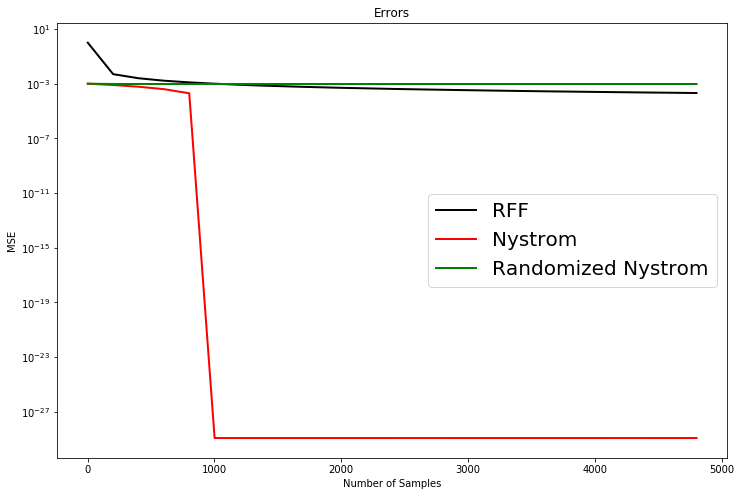

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

errors_rff, errors_rnystrom, errors_nystrom = np.array(errors_rff), np.array(errors_rnystrom), np.array(errors_nystrom)


fig, ax = plt.subplots(figsize=(12,8))

ax.plot(Ds, errors_rff, label='RFF', linewidth=2, color='k')
ax.plot(Ds, errors_nystrom, label='Nystrom', linewidth=2, color='r')
ax.plot(Ds, errors_rnystrom, label='Randomized Nystrom', linewidth=2, color='g')
ax.set_xlabel('Number of Samples')
ax.set_ylabel('MSE')
ax.set_yscale("log")
ax.set_title('Errors')
ax.legend(fontsize=20)
plt.show()